In [ ]:
!nvidia-smi

Tue Mar 23 18:40:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    46W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split
import zipfile
import os
import PIL.Image as Image
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

In [ ]:
def imshow(img, ax=None):
    img = np.squeeze(img)

    if img.ndim == 2:  # black-and-white
        if ax is None:
            return plt.imshow(img, vmin=0, vmax=1, cmap='gray_r')
        else:
            return ax.imshow(img, vmin=0, vmax=1, cmap='gray_r')
    elif img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
        if ax is None:
            return plt.imshow(img, vmin=0, vmax=1)
        else:
            return ax.imshow(img, vmin=0, vmax=1)
    else:
        raise Exception(f'img has shape {img.shape}')



def create_rect_mask(img, radius=4):
    assert img.ndim == 2 or img.ndim == 3

    if img.ndim == 3:
        nonz = np.nonzero(img)
        y, x = nonz[:, 1], nonz[:, 2]
    else:
        y, x = np.nonzero(img)
    i = np.random.randint(len(x))
    x = x[i]
    y = y[i]
    mask = np.ones(img.shape[-2:], dtype=np.bool)
    left = max(0, x - radius)
    right = min(img.shape[-1], x + radius + 1)

    top = max(0, y - radius)
    bottom = min(img.shape[-2], y + radius + 1)

    mask[top:bottom, left:right] = 0

    return mask

In [ ]:
!rm -rf data_faces
!mkdir data_faces

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2021-03-23 18:40:19--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.152
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.2’

celeba.zip.2        100%[===================>]   1.34G  20.5MB/s    in 69s     

2021-03-23 18:41:29 (19.9 MB/s) - ‘celeba.zip.2’ saved [1443490838/1443490838]



In [ ]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
crop_size = 108
re_size = 48
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize(size=(re_size, re_size), interpolation=transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
    ]
)

celeba_data = torchvision.datasets.ImageFolder('./data_faces', transform=transform)

In [ ]:
class CelebaDataset(Dataset):
    def __init__(self, root_dir, mask_creator, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.size = len(os.listdir(self.root_dir))
        self.transform = transform
        self.mask_creator = mask_creator

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        image_path = self.root_dir + f'/{index+1:0>6}.jpg'
        img = Image.open(image_path)
        img = self.transform(img)
        mask = self.mask_creator(img)

        mask = torch.tensor(mask[np.newaxis], dtype=torch.bool)

        return img, mask

In [ ]:
celeba_data = CelebaDataset('data_faces/img_align_celeba', create_rect_mask, transform=transform)

train_size = round(len(celeba_data)*.9)
test_size = round(len(celeba_data)*.1)
rest = len(celeba_data) - train_size - test_size

celeba_train_data, celeba_test_data, _ = random_split(celeba_data, [train_size, test_size, rest])

len(celeba_train_data), len(celeba_test_data)

(182339, 20260)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


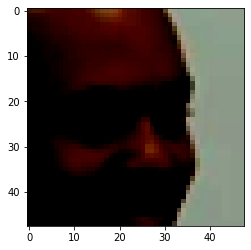

In [ ]:
img, mask = celeba_train_data[0]
imshow(img * mask)


In [ ]:
from torch import nn

In [ ]:
class CAInpaintig(torch.nn.Module):
    def __init__(self, img_channels, state_size, hidden_size):
        super(CAInpaintig, self).__init__()
        
        self.state_size = state_size

        # img_channels for img + 1 for mask
        self.conv1 = nn.Conv2d(in_channels=img_channels + 1 + state_size,
                               out_channels=hidden_size,
                               kernel_size=(3, 3),
                               padding=1)
        self.activation1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=hidden_size,
                               out_channels=hidden_size,
                               kernel_size=(1, 1))
        self.activation2 = nn.ReLU()

        self.conv_state = nn.Conv2d(in_channels=hidden_size,
                                    out_channels=state_size,
                                    kernel_size=(1, 1))
        
        self.conv_img = nn.Conv2d(in_channels=hidden_size,
                                  out_channels=img_channels,
                                  kernel_size=(1, 1))
        
    def forward(self, img, mask, state):
        x = torch.cat((img, mask, state), dim=1)

        x = self.activation1(self.conv1(x))
        x = self.activation2(self.conv2(x))

        img_pred = self.conv_img(x)
        state_update = self.conv_state(x)

        return img_pred, state_update

    def gen_initial_state(self, batch_shape):
        return torch.randn((batch_shape[0], self.state_size, batch_shape[2], batch_shape[3]))

In [ ]:
def update_img_and_state(img, mask, state, img_pred, state_update, device='cuda'):
    # Img has only one channel
    mask_update = torch.ones_like(mask) / 2
    mask_update = torch.bernoulli(mask_update).bool()
    mask_update = mask_update.to(device)

    # Update state according to bernoulli
    state += state_update * mask_update

    # Update unknown part of an image according to bernoulli
    # There are 3 types of pixels:
    # 1. Known pixels (indicated by mask)
    # 2. Unknown pixels to update (indicated by ~mask and mask_update)
    # 3. Unknown pixels without update (indicated by ~mask and ~mask_update)
    # mask_update = torch.squeeze(mask_update)
    # img_pred = torch.squeeze(img_pred)
    img = mask * img + (~mask) * (mask_update * img_pred + (~mask_update) * img)

    return img, state

In [ ]:
from tqdm.notebook import tqdm

def test(epoch, net, criterion,
         val_loader,
         without_loss_iters=1, with_loss_iters=1,
         device='cuda'):
    net.to(device)
    net.eval()
    with torch.no_grad():
        losses_val = []
        pbar = tqdm(val_loader, desc=f'Valid (epoch = {epoch})')
        for img, mask in pbar:
            state = net.gen_initial_state(img.shape)

            img, mask, state = img.to(device), mask.to(device), state.to(device)

            original_img = img.detach().clone()

            # Perform one step of minibatch stochastic gradient descent
            for _ in range(without_loss_iters):
                img_pred, state_update = net(img * mask, mask, state)
                img, state = update_img_and_state(img, mask, state,
                                                img_pred, state_update,
                                                device=device)

            loss = 0
            for _ in range(with_loss_iters):
                img_pred, state_update = net(img * mask, mask, state)
                img, state = update_img_and_state(img, mask, state,
                                                img_pred, state_update,
                                                device=device)

                # loss += criterion(torch.squeeze(img_pred), original_img)
                loss += criterion(img_pred, original_img)
                # loss += criterion(img, original_img)

            # Take last prediction
            # loss = criterion(torch.squeeze(img_pred), original_img)

            losses_val.append(loss.item())
            pbar.set_postfix({'loss': sum(losses_val) / len(losses_val)})
        return losses_val


def train(epochs, net, criterion, optimizer,
          train_loader, val_loader,
          without_loss_iters=1, with_loss_iters=1,
          scheduler=None, verbose=True, device='cuda'):
    net.to(device)
    freq = max(epochs//15,1)

    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        pbar = tqdm(train_loader, desc=f'Train (epoch = {epoch})')
        for img, mask in pbar:
            state = net.gen_initial_state(img.shape)

            img, mask, state = img.to(device), mask.to(device), state.to(device)

            original_img = img.detach().clone()

            # Perform one step of minibatch stochastic gradient descent
            for _ in range(without_loss_iters):
                img_pred, state_update = net(img * mask, mask, state)
                img, state = update_img_and_state(img, mask, state,
                                                  img_pred, state_update,
                                                  device=device)

            loss = 0
            for _ in range(with_loss_iters):
                img_pred, state_update = net(img * mask, mask, state)
                img, state = update_img_and_state(img, mask, state,
                                                  img_pred, state_update,
                                                  device=device)

                # loss += criterion(torch.squeeze(img_pred), original_img)
                loss += criterion(img_pred, original_img)
                # loss += criterion(img, original_img)

            # Take last prediction
            # loss = criterion(torch.squeeze(img_pred), original_img)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            losses_train.append(loss.item())
            pbar.set_postfix({'loss': sum(losses_train) / len(losses_train)})

        if scheduler is not None:
            scheduler.step()


        if verbose and epoch % freq == 0:
            net.eval()
            losses_val = []
            pbar = tqdm(val_loader, desc=f'Valid (epoch = {epoch})')
            for img, mask in pbar:
                state = net.gen_initial_state(img.shape)

                img, mask, state = img.to(device), mask.to(device), state.to(device)

                original_img = img.detach().clone()

                # Perform one step of minibatch stochastic gradient descent
                for _ in range(without_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                loss = 0
                for _ in range(with_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                    # loss += criterion(torch.squeeze(img_pred), original_img)
                    loss += criterion(img_pred, original_img)
                    # loss += criterion(img, original_img)

                # Take last prediction
                # loss = criterion(torch.squeeze(img_pred), original_img)

                losses_val.append(loss.item())
                pbar.set_postfix({'loss': sum(losses_val) / len(losses_val)})

In [ ]:
STATE_SIZE = 30
HIDDEN_SIZE = 64
# MASK_RADIUS = 4  # size will be (2 * MASK_RADIUS + 1, 2 * MASK_RADIUS + 1)
BATCH_SIZE = 128

In [ ]:
IMG_CHANNELS = 3
train_loader = DataLoader(celeba_train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(celeba_test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
from skimage.metrics import structural_similarity as ssim

### Experiments

#### Comparison of different loss function: L1 / MSE for training baseline model neural network 

In [ ]:
net = CAInpaintig(img_channels=3, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.31)

In [ ]:
net2 = CAInpaintig(img_channels=3, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.31)

training L1 loss

In [ ]:
train(5, net, criterion, optimizer,
      train_loader, val_loader,
      without_loss_iters=15, with_loss_iters=5,
      scheduler=scheduler, verbose=True, device='cuda')

In [ ]:
torch.save(net.state_dict(), '5epochsl1loss.pt')

In [ ]:
net.load_state_dict(torch.load('5epochsl1loss.pt'))
net.eval()

CAInpaintig(
  (conv1): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (activation2): ReLU()
  (conv_state): Conv2d(64, 30, kernel_size=(1, 1), stride=(1, 1))
  (conv_img): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
train(5, net2, criterion, optimizer,
      train_loader, val_loader,
      without_loss_iters=15, with_loss_iters=5,
      scheduler=scheduler, verbose=True, device='cuda')

Text(0, 0.5, 'Loss')

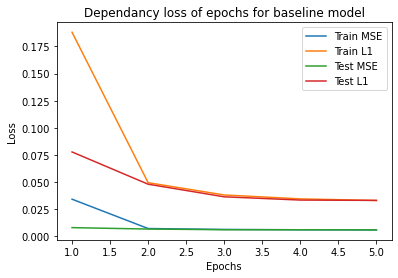

In [ ]:
train_loss_mse = [0.0343, 0.00729, 0.00645, 0.00615, 0.00602]
train_loss_mae = [0.188, 0.0495, 0.0382, 0.0346, 0.0331]
test_loss_mse = [0.00812, 0.00682, 0.0062, 0.00617, 0.00605]
test_loss_mae = [0.0778, 0.0481, 0.0365, 0.0335, 0.0332]

plt.plot(np.arange(5) + 1 , train_loss_mse, label='Train MSE')
plt.plot(np.arange(5) + 1, train_loss_mae, label='Train L1')
plt.plot(np.arange(5) + 1, test_loss_mse, label='Test MSE')
plt.plot(np.arange(5) + 1, test_loss_mae, label='Test L1')
plt.legend()
plt.title('Dependancy loss of epochs for baseline model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
torch.save(net2.state_dict(), '5epochsmseloss.pt')

In [ ]:
test(5, net2, criterion,
     val_loader,
     without_loss_iters=15, with_loss_iters=5,
     device='cuda')

[0.006260116584599018,
 0.005864919163286686,
 0.006669229362159967,
 0.005996473133563995,
 0.005500222090631723,
 0.006334222387522459,
 0.0062142484821379185,
 0.006244583986699581,
 0.006216755136847496,
 0.005546838045120239,
 0.005672025959938765,
 0.005688849370926619,
 0.006186475977301598,
 0.006380995735526085,
 0.006588468328118324,
 0.006453732959926128,
 0.005322595126926899,
 0.006692687980830669,
 0.005723993759602308,
 0.005656329449266195,
 0.006121341604739428,
 0.005707599688321352,
 0.005711730569601059,
 0.005268776323646307,
 0.006230518221855164,
 0.005508400499820709,
 0.0064348336309194565,
 0.006385878659784794,
 0.005982033908367157,
 0.005945987068116665,
 0.0060213771648705006,
 0.0054969387128949165,
 0.006513950414955616,
 0.006630222778767347,
 0.006443306803703308,
 0.005923660937696695,
 0.005586607381701469,
 0.006129371002316475,
 0.005008633714169264,
 0.006129800342023373,
 0.006229599937796593,
 0.005590306594967842,
 0.005798459984362125,
 0.0066

In [ ]:
# Gets batch of images
def predict_all(net, img, mask, iters=1, device='cuda'):
    state = net.gen_initial_state(img.shape)

    img, mask, state = img.to(device), mask.to(device), state.to(device)

    imgs_pred = torch.empty((iters,) + img.shape)
    for i in range(iters):
        img_pred, state_update = net(img * mask, mask, state)

        img, state = update_img_and_state(img, mask, state, img_pred, state_update, device=device)

        imgs_pred[i] = img_pred.cpu().detach()

    return imgs_pred

# Gets batch of images
def predict(net, img, mask, iters=1, device='cuda'):
    return predict_all(net, img, mask, iters, device)[-1]

def show_prediction(net, img, mask, img_pred, iters=1, n_rows=1, idx=0, device='cuda'):
    n_cols = 5
    if n_rows == 1:
        plt.figure(figsize=(16, 3))

    plt.subplot(n_rows, n_cols, idx * n_cols + 1)
    plt.title('Original image')
    imshow(img)

    plt.subplot(n_rows, n_cols, idx * n_cols + 2)
    plt.title('Mask')
    imshow(mask.type(torch.float32))

    plt.subplot(n_rows, n_cols, idx * n_cols + 3)
    plt.title('Masked image')
    imshow(img * mask)

    plt.subplot(n_rows, n_cols, idx * n_cols + 4)
    plt.title('Reconstructed image')
    imshow(img_pred)

    plt.subplot(n_rows, n_cols, idx * n_cols + 5)
    plt.title('Difference image')
    imshow(np.abs(img_pred - img))
    #print(img_pred.shape)
    #print('............')
    #print(img.shape)
    #print('PSNR for images: ', cv.PSNR(img_pred.numpy(), img.numpy()))
    #print('SSIM for images: ', ssim(img_pred.numpy()[:1], img.numpy()[:1]))
    #print('FID for images: ', cv.FID)

# Gets batch of images
def show_predictions(net, imgs, masks, iters=1, device='cuda'):
    n_rows = len(imgs)
    
    imgs_pred = predict(net, imgs, masks, iters=iters, device=device)
    for i in range(len(imgs)):
      print('PSNR for images: ', cv.PSNR(imgs_pred[i].numpy(), imgs[i].numpy()))
      print('SSIM for images: ', ssim(imgs_pred[i][:,:,:][0].numpy(), imgs[i][:,:,:][0].numpy()))
      print('FID for images: ', calculate_fid(imgs_pred[i][0].numpy(), imgs[i][0].numpy()))
    plt.figure(figsize=(16, 3.5 * n_rows))
    for idx in range(n_rows):
        show_prediction(net, imgs[idx], masks[idx], imgs_pred[idx],
                        iters=iters, n_rows=n_rows, idx=idx,
                        device=device)
    



In [ ]:
from scipy.linalg import sqrtm
import cv2 as cv
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
net2 = CAInpaintig(img_channels=3, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)
net2.load_state_dict(torch.load('2epochs.pt'))
net2.eval()

CAInpaintig(
  (conv1): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (activation2): ReLU()
  (conv_state): Conv2d(64, 30, kernel_size=(1, 1), stride=(1, 1))
  (conv_img): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
test(2, net2, criterion,
     val_loader,
     without_loss_iters=15, with_loss_iters=5,
     device='cuda')

[0.06218787655234337,
 0.06334124505519867,
 0.06021972745656967,
 0.06321008503437042,
 0.06374698132276535,
 0.06144502013921738,
 0.06114643067121506,
 0.06428895890712738,
 0.060873232781887054,
 0.06399112939834595,
 0.062406182289123535,
 0.06432089954614639,
 0.06194125488400459,
 0.061815112829208374,
 0.063894122838974,
 0.06257665902376175,
 0.06351891160011292,
 0.06091786548495293,
 0.0610494501888752,
 0.06510356813669205,
 0.06204278767108917,
 0.06285449117422104,
 0.06347385048866272,
 0.06024397537112236,
 0.06355178356170654,
 0.06353529542684555,
 0.06380762904882431,
 0.06248188018798828,
 0.06334253400564194,
 0.06023034453392029,
 0.06272097676992416,
 0.06274496018886566,
 0.0642978847026825,
 0.06261987239122391,
 0.06319853663444519,
 0.06102469563484192,
 0.06448756158351898,
 0.06136567145586014,
 0.06342615187168121,
 0.06140056625008583,
 0.06103070452809334,
 0.0634905993938446,
 0.06218275427818298,
 0.062237441539764404,
 0.06226067245006561,
 0.06201090

In [ ]:
net = CAInpaintig(img_channels=3, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)
net.load_state_dict(torch.load('5epochsl1loss.pt'))
net.eval()
net2 = CAInpaintig(img_channels=3, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)
net2.load_state_dict(torch.load('5epochsmseloss.pt'))
net2.eval()

CAInpaintig(
  (conv1): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (activation2): ReLU()
  (conv_state): Conv2d(64, 30, kernel_size=(1, 1), stride=(1, 1))
  (conv_img): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
test(5, net2, criterion,
     val_loader,
     without_loss_iters=15, with_loss_iters=5,
     device='cuda')

[0.005085221491754055,
 0.0061715650372207165,
 0.006267318036407232,
 0.006406035739928484,
 0.005666536744683981,
 0.006436608731746674,
 0.00521229999139905,
 0.005852283909916878,
 0.006342071108520031,
 0.006331481505185366,
 0.00589623861014843,
 0.005799278616905212,
 0.005813321098685265,
 0.007542387116700411,
 0.006131366826593876,
 0.0061517562717199326,
 0.0055385977029800415,
 0.00501216622069478,
 0.007319753989577293,
 0.006099815014749765,
 0.006551289930939674,
 0.0062414249405264854,
 0.007549966219812632,
 0.005772781558334827,
 0.00612629484385252,
 0.005035933572798967,
 0.0061201550997793674,
 0.005363256670534611,
 0.0056394850835204124,
 0.007558879442512989,
 0.005220855586230755,
 0.0062738326378166676,
 0.005771843250840902,
 0.006344006396830082,
 0.005515614058822393,
 0.006820702459663153,
 0.007256151642650366,
 0.005342175252735615,
 0.006852643098682165,
 0.006026069168001413,
 0.00549689307808876,
 0.006164888851344585,
 0.00703375693410635,
 0.0055866

In [ ]:
test(5, net, criterion,
     val_loader,
     without_loss_iters=15, with_loss_iters=5,
     device='cuda')

[0.007502139080315828,
 0.007533973082900047,
 0.007440448272973299,
 0.00691240094602108,
 0.00649343291297555,
 0.0060709691606462,
 0.00722642382606864,
 0.007476691622287035,
 0.007630820386111736,
 0.00781575869768858,
 0.008341793902218342,
 0.00723636569455266,
 0.006676268298178911,
 0.006475493777543306,
 0.007236243691295385,
 0.007731974124908447,
 0.0083151301369071,
 0.008068256080150604,
 0.007544719148427248,
 0.006970969494432211,
 0.0072539024986326694,
 0.006671037059277296,
 0.009513698518276215,
 0.006996897514909506,
 0.0076503390446305275,
 0.006844261195510626,
 0.008277252316474915,
 0.0073669664561748505,
 0.006820359267294407,
 0.006790178827941418,
 0.008120839484035969,
 0.0072271134704351425,
 0.007855852134525776,
 0.007163165137171745,
 0.006947837304323912,
 0.00716685876250267,
 0.007548034191131592,
 0.006753419525921345,
 0.007390646729618311,
 0.007140622474253178,
 0.007685700431466103,
 0.008078699000179768,
 0.007330401800572872,
 0.00728140072897

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for images:  82.47614895634035
SSIM for images:  0.9812197817836446
FID for images:  0.024211337736962903
PSNR for images:  80.14099595759853
SSIM for images:  0.9860802357601471
FID for images:  0.010786863832375189
PSNR for images:  79.97348624689108
SSIM for images:  0.9736214958904024
FID for images:  0.012245920166519837
PSNR for images:  76.41766973255864
SSIM for images:  0.9729846885247477
FID for images:  0.07835269443945195
PSNR for images:  80.16909322133577
SSIM for images:  0.9898311648955052
FID for images:  0.020248304193076973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

PSNR for images:  84.130015483432
SSIM for images:  0.9853717681844916
FID for images:  0.014670048758566798
PSNR for images:  80.48441758191976
SSIM for images:  0.9815877982497021
FID for images:  0.014057871086323455
PSNR for images:  78.74870491359115
SSIM for images:  0.9661100886714907
FID for images:  0.01870361762970016
PSNR for images:  75.09401346067028
SSIM for images:  0.9846401087471844
FID for images:  0.06899651188387397
PSNR for images:  83.10775387343197
SSIM for images:  0.9956679810282175
FID for images:  0.010169031792121147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

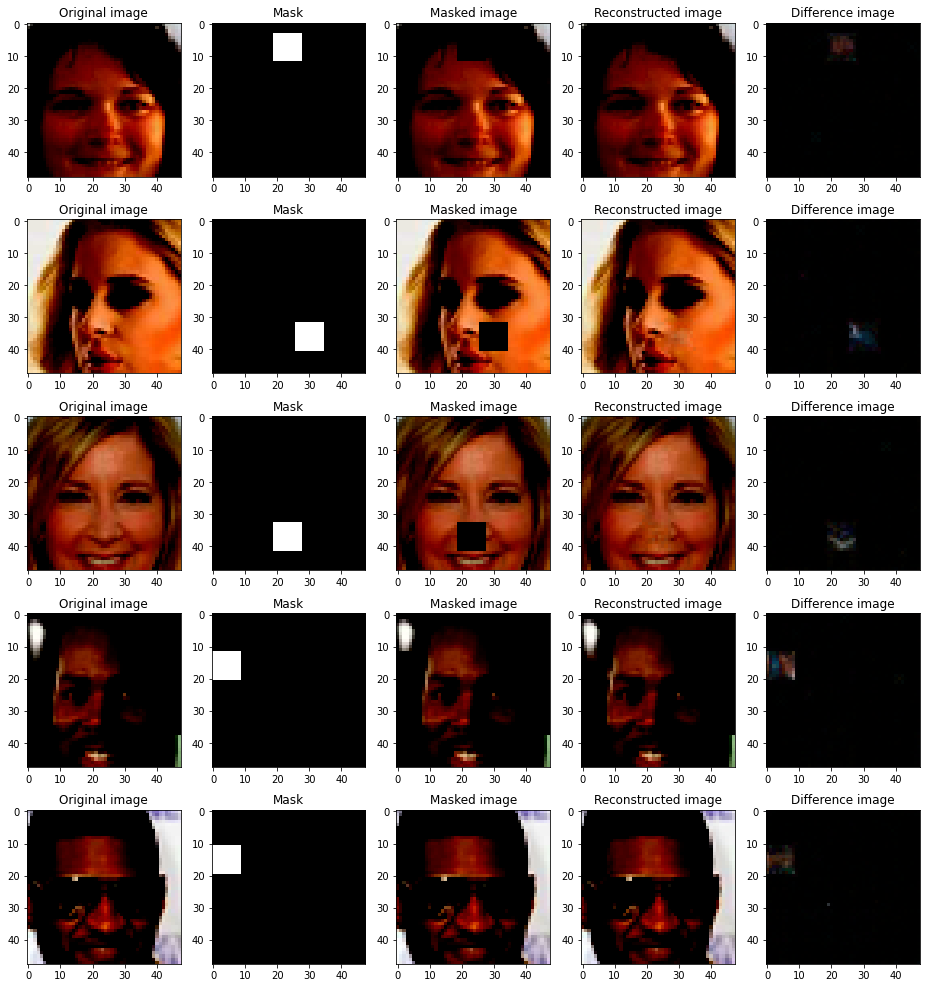

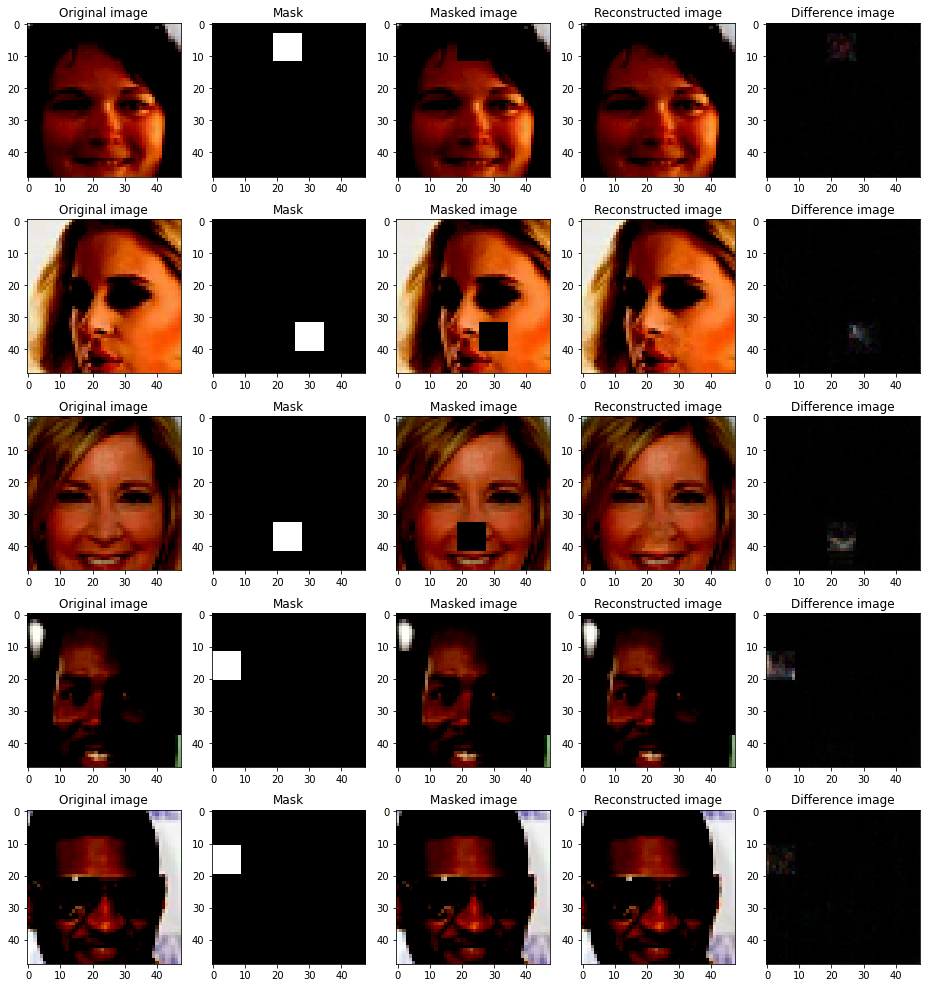

In [ ]:
imgs, masks = next(iter(val_loader))
amount_images = 5
show_predictions(net, imgs[:amount_images], masks[:amount_images], iters=15)
show_predictions(net2, imgs[:amount_images], masks[:amount_images], iters=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for images:  75.60257352117867
SSIM for images:  0.9632229562952911
FID for images:  0.12141146119239615
PSNR for images:  75.28678182796398
SSIM for images:  0.9610982166962503
FID for images:  0.11256578355097263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1152x252 with 0 Axes>

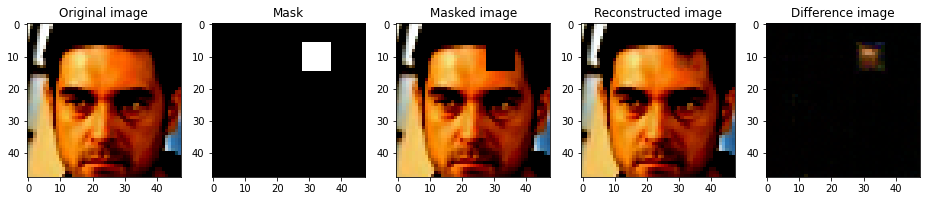

<Figure size 1152x252 with 0 Axes>

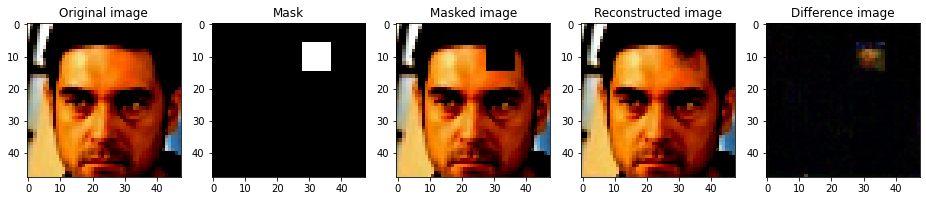

In [ ]:

imgs, masks = next(iter(val_loader))
amount_images = 1
show_predictions(net, imgs[:amount_images], masks[:amount_images], iters=15)
show_predictions(net2, imgs[:amount_images], masks[:amount_images], iters=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for images:  82.86526739565704
SSIM for images:  0.9791429543434388
FID for images:  0.013195719898918417


<Figure size 1152x252 with 0 Axes>

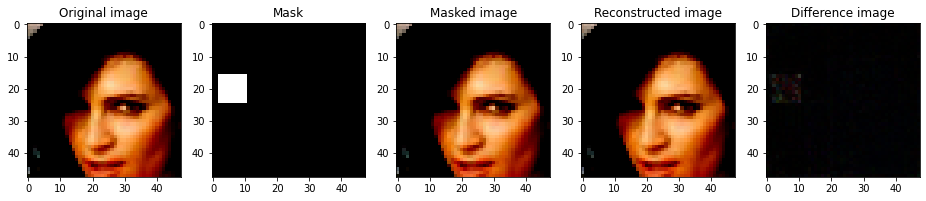

In [ ]:
show_predictions(net2, imgs[:amount_images], masks[:amount_images], iters=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for images:  78.29168854698017
SSIM for images:  0.9914184306170893
FID for images:  0.017033378251976046


<Figure size 1152x252 with 0 Axes>

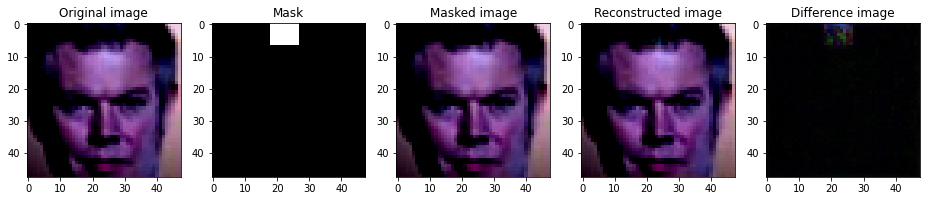

In [ ]:
imgs, masks = next(iter(val_loader))
amount_images = 1
show_predictions(net, imgs[:amount_images], masks[:amount_images], iters=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

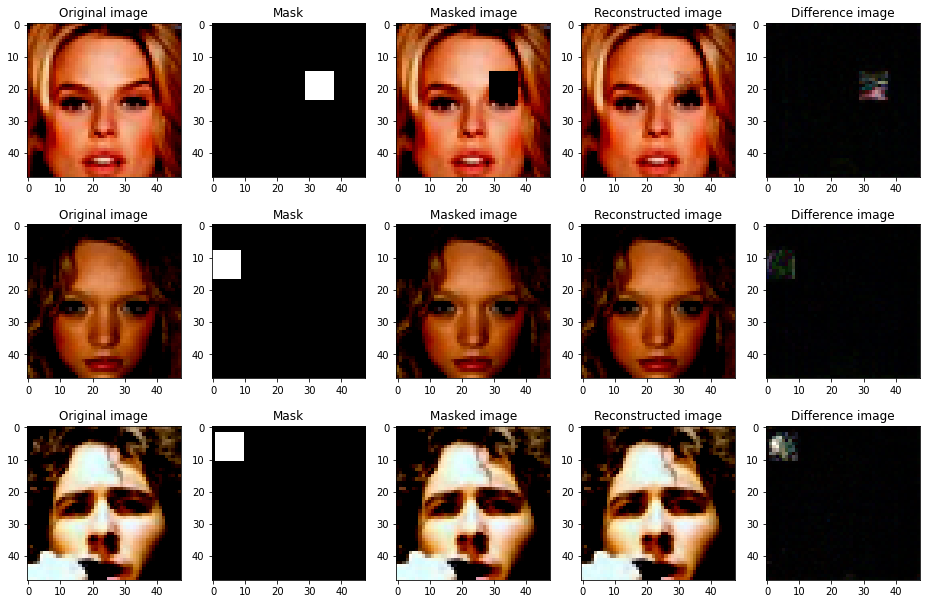

In [ ]:
imgs, masks = next(iter(val_loader))

show_predictions(net, imgs[:3], masks[:3], iters=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

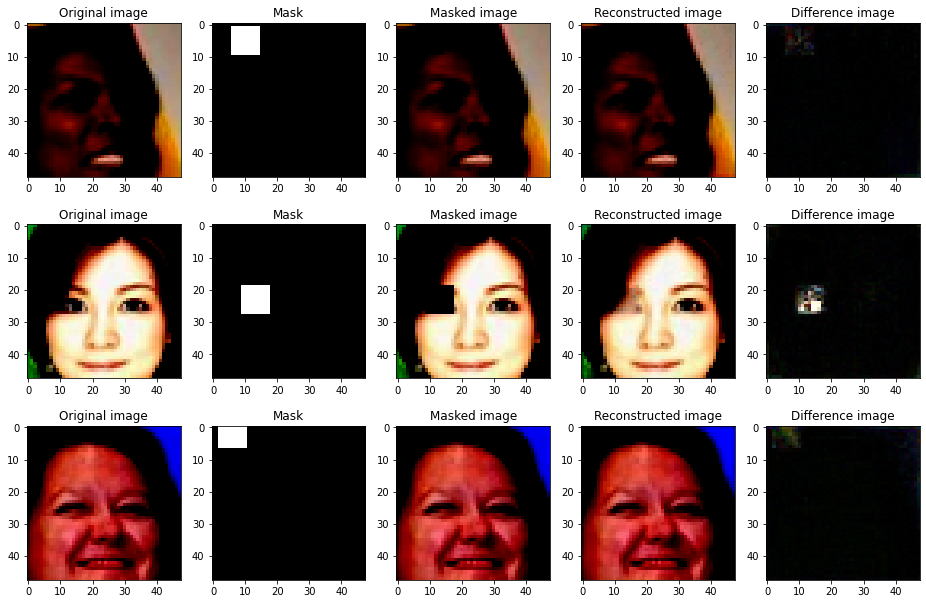

In [ ]:
imgs, masks = next(iter(val_loader))

show_predictions(net, imgs[:3], masks[:3], iters=15)